Modularize functions for scaling and labeling so easier to test different configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocess
from collections import Counter
import pprint
from scipy.stats import chisquare

pp = pprint.PrettyPrinter(indent=4)

In [2]:
data = pd.read_csv("TopCharts_unique.csv", index_col = 0)

In [3]:
cluster_df = data.drop(columns = ["Time Signature", "Key", "Mode","Instrumentalness", "Acousticness", "Days"])

In [5]:
def scaleData(scaler, data, firstCol):
    mms = scaler()
    cluster_values = data.iloc[:,firstCol:]
    mms.fit(cluster_values)
    return mms.transform(cluster_values)

In [6]:
data_transformed = scaleData(preprocess.StandardScaler, cluster_df, 3)

In [7]:
def plotKMeans(data, minCluster, maxCluster):
    inertias = []
    for i in range(minCluster, maxCluster):
        kmeans = KMeans(n_clusters = i).fit(data)
        inertias.append(kmeans.inertia_)    
    
    plt.plot(range(1,len(inertias)+1), inertias, "bx-")
    plt.xlabel('k')
    plt.ylabel("Inertia")
    plt.xticks(range(1,len(inertias)+1))
    plt.show()
    
    
    diffs = np.array(inertias[1:]) - np.array(inertias[:len(inertias)-1])
    plt.plot(range(1,len(inertias)+1), [-inertias[0]] + list(diffs),"bx-")
    plt.ylabel("Change in Inertia")
    plt.xticks(range(1,len(inertias)+1))

    plt.show()
    
    return(inertias)
    

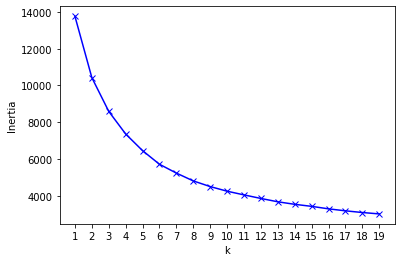

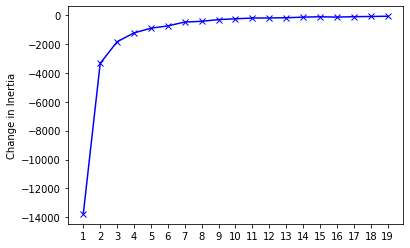

In [8]:
inertias = plotKMeans(data_transformed, 1, 20)

In [9]:
def fitKMeans(data, clusters):
    labels_df = cluster_df.copy()
    kmeans_opt = KMeans(n_clusters = clusters).fit(data)
    labels_df["Label"] = kmeans_opt.labels_
    

    groups ={}
    counters = {}
    for i in range(clusters):
        groups[i] = labels_df[labels_df["Label"] == i]
        counters[i] = Counter(groups[i]["Artist"])
    
    return groups, counters

In [50]:
cluster_df_subset, cluster_artist_counter = fitKMeans(data_transformed, 13)

In [51]:
def getClusterSongs(cluster_num, groups, counters, artists = [], n_artists = 3):
    cnt = counters[cluster_num]
    grp = groups[cluster_num]
    artsong = {}
    if artists:
        assert(set(artists).issubset(set(cnt.keys())))
    else:
        n_artists = min(n_artists, len(cnt.keys()))
        artists = [a[0] for a in cnt.most_common(n_artists)]
    for artist in artists:
        artsong[artist] = list(grp[grp["Artist"] == artist]["Title"])
    return artsong

In [52]:
artist_json = pd.read_json("groupedArtistData.json")

In [53]:
artist_data = artist_json.transpose()

In [54]:
def getClusterGenres(artist_counter, artist_genre_df):
    genre_clusters = dict() #cluster num, artist genres
    most_freq = dict() #cluster num, most freq genre
    for i in artist_counter.keys():
        cluster_artist = artist_counter[i]
        cluster_genres = []
        for k in cluster_artist.keys():
            try:
                g = artist_genre_df.loc[k, "Genres"]
                for _ in range(cluster_artist[k]):
                    cluster_genres.extend(g)
            except:
                print(f"{k} is not in artist_data")

        cluster_cnt = Counter(cluster_genres) 
        genre_clusters[i] = dict(sorted(cluster_cnt.items()))
        most_freq[i] = cluster_cnt.most_common(1)
    return (genre_clusters, most_freq)

In [55]:
cluster_genre_counts_raw, cluster_classes = getClusterGenres(cluster_artist_counter, artist_data)

Ray Parker, Jr. is not in artist_data
The Black Eyed Peas is not in artist_data
ToKeith is not in artist_data
Bob"Boris" Pickett is not in artist_data
BobHelms is not in artist_data
BaKeem is not in artist_data
Yung Anime is not in artist_data
Lil Monet is not in artist_data
Lil Adrei is not in artist_data
The 7 Dimensions is not in artist_data
GabBarrett is not in artist_data


In [56]:
pp.pprint(cluster_classes)

{   0: [('pop', 102)],
    1: [('rap', 328)],
    2: [('pop', 223)],
    3: [('rap', 215)],
    4: [('pop', 229)],
    5: [('rap', 18)],
    6: [('pop', 137)],
    7: [('pop', 190)],
    8: [('pop', 252)],
    9: [('rap', 342)],
    10: [('pop', 148)],
    11: [('pop', 144)],
    12: [('pop', 98)]}


In [57]:
pp.pprint(cluster_genre_counts_raw)

{   0: {   'adult standards': 1,
           'country': 6,
           'edm': 10,
           'hip hop': 55,
           'house': 17,
           'indie': 9,
           'latin': 1,
           'other': 8,
           'pop': 102,
           'r&b': 10,
           'rap': 97,
           'rock': 27,
           'trap': 33},
    1: {   'country': 1,
           'edm': 1,
           'hip hop': 260,
           'house': 2,
           'indie': 5,
           'latin': 4,
           'pop': 261,
           'r&b': 19,
           'rap': 328,
           'rock': 4,
           'trap': 233},
    2: {   'adult standards': 7,
           'country': 14,
           'edm': 18,
           'hip hop': 103,
           'house': 20,
           'indie': 11,
           'latin': 31,
           'other': 11,
           'pop': 223,
           'r&b': 9,
           'rap': 147,
           'rock': 33,
           'trap': 82},
    3: {   'adult standards': 13,
           'country': 7,
           'edm': 3,
           'hip hop': 174,
     

In [58]:
def getTotalGenreCounts(artist_df):
    l = []
    for g in artist_df.Genres:
        l.extend(g)

    return dict(sorted(Counter(l).items()))

In [59]:
total_genre_counts = getTotalGenreCounts(artist_data)

In [60]:
pp.pprint(total_genre_counts)

{   'adult standards': 35,
    'country': 51,
    'edm': 43,
    'hip hop': 139,
    'house': 51,
    'indie': 48,
    'latin': 26,
    'other': 49,
    'pop': 383,
    'r&b': 42,
    'rap': 215,
    'rock': 101,
    'trap': 124}


In [61]:
all_genres = list(total_genre_counts.keys())

In [62]:
def convertCountstoProps(counts_dict):
    """
    input: dict of genre counts
    output: dict of genre proportions 
    """
    tc = sum(counts_dict.values())
    props = dict()
    for k in counts_dict.keys():
        props[k] = counts_dict[k]/tc
    cnt = Counter(props)
    return dict(sorted(cnt.items()))

In [63]:
total_genre_props = convertCountstoProps(total_genre_counts)

In [64]:
pp.pprint(total_genre_props)

{   'adult standards': 0.026778882938026015,
    'country': 0.03902065799540933,
    'edm': 0.03289977046671767,
    'hip hop': 0.1063504208110176,
    'house': 0.03902065799540933,
    'indie': 0.036725325172149964,
    'latin': 0.019892884468247895,
    'other': 0.03749043611323642,
    'pop': 0.2930374904361132,
    'r&b': 0.032134659525631215,
    'rap': 0.16449885233358838,
    'rock': 0.0772762050497322,
    'trap': 0.09487375669472073}


In [65]:
def getClusterProps(cluster_counts_dict):
    """
    input: dict of Counters of genre counts in each cluster
    output: dict of Counters of genre proportions in each cluster
    """
    return {list(cluster_counts_dict.keys())[i]:               \
            convertCountstoProps(cluster_counts_dict[i]) \
            for i in list(cluster_counts_dict.keys())}


In [66]:
def alignClusterGenres(cluster_counts_dict, all_genres):
    """
    input:    dict of Counters of genre counts in each cluster;
              list of all possible genres in entire dataset 
    output:   dict of Counters of genre counts in each cluster
    purpose:  ensures that all genres in dataset appear in cluster; if 
              a genre is missing from the cluster, add the genre to the cluster
              with value 0
    """
    all_keys = set(all_genres)
    for i in cluster_counts_dict.keys():
        cluster = cluster_counts_dict[i]
        cluster_keys = cluster.keys()
        for k in all_keys - cluster_keys:
            cluster[k] = 0
    return cluster_counts_dict 

In [67]:
cluster_genre_counts = alignClusterGenres(cluster_genre_counts_raw, all_genres)

In [68]:
pp.pprint(cluster_genre_counts)

{   0: {   'adult standards': 1,
           'country': 6,
           'edm': 10,
           'hip hop': 55,
           'house': 17,
           'indie': 9,
           'latin': 1,
           'other': 8,
           'pop': 102,
           'r&b': 10,
           'rap': 97,
           'rock': 27,
           'trap': 33},
    1: {   'adult standards': 0,
           'country': 1,
           'edm': 1,
           'hip hop': 260,
           'house': 2,
           'indie': 5,
           'latin': 4,
           'other': 0,
           'pop': 261,
           'r&b': 19,
           'rap': 328,
           'rock': 4,
           'trap': 233},
    2: {   'adult standards': 7,
           'country': 14,
           'edm': 18,
           'hip hop': 103,
           'house': 20,
           'indie': 11,
           'latin': 31,
           'other': 11,
           'pop': 223,
           'r&b': 9,
           'rap': 147,
           'rock': 33,
           'trap': 82},
    3: {   'adult standards': 13,
           'country': 

In [69]:
cluster_genre_props = getClusterProps(cluster_genre_counts)
#dict of Counters of genre proportions in each cluster

In [70]:
pp.pprint(cluster_genre_props)

{   0: {   'adult standards': 0.0026595744680851063,
           'country': 0.015957446808510637,
           'edm': 0.026595744680851064,
           'hip hop': 0.14627659574468085,
           'house': 0.04521276595744681,
           'indie': 0.023936170212765957,
           'latin': 0.0026595744680851063,
           'other': 0.02127659574468085,
           'pop': 0.2712765957446808,
           'r&b': 0.026595744680851064,
           'rap': 0.2579787234042553,
           'rock': 0.07180851063829788,
           'trap': 0.08776595744680851},
    1: {   'adult standards': 0.0,
           'country': 0.0008944543828264759,
           'edm': 0.0008944543828264759,
           'hip hop': 0.23255813953488372,
           'house': 0.0017889087656529517,
           'indie': 0.004472271914132379,
           'latin': 0.0035778175313059034,
           'other': 0.0,
           'pop': 0.2334525939177102,
           'r&b': 0.01699463327370304,
           'rap': 0.29338103756708406,
           'rock': 0.00

In [103]:
def propDiff(overall_props, cluster_props):
    """
    inputs: Counter of proportions of artist genres in overall dataset; 
            Counter of proportions of artist genres in single cluster
    output: Counter of absolute differences in artist genre proportions between
            overall dataset and single cluster
    """
    return {k:float(cluster_props[k] - overall_props[k]) \
            for k in overall_props.keys()}

In [104]:
def getPropDiffs(overall_props, cluster_props_dict):
    out = dict()
    for i in cluster_props_dict.keys():
        out[i] = propDiff(overall_props, cluster_props_dict[i])
    return out
    

In [105]:
prop_diffs = getPropDiffs(total_genre_props, cluster_genre_props)
pp.pprint(prop_diffs)

{   0: {   'adult standards': -0.024119308469940908,
           'country': -0.023063211186898695,
           'edm': -0.006304025785866609,
           'hip hop': 0.03992617493366325,
           'house': 0.00619210796203748,
           'indie': -0.012789154959384007,
           'latin': -0.017233310000162788,
           'other': -0.01621384036855557,
           'pop': -0.021760894691432386,
           'r&b': -0.005538914844780151,
           'rap': 0.09347987107066694,
           'rock': -0.005467694411434326,
           'trap': -0.0071077992479122165},
    1: {   'adult standards': -0.026778882938026015,
           'country': -0.03812620361258286,
           'edm': -0.0320053160838912,
           'hip hop': 0.1262077187238661,
           'house': -0.03723174922975638,
           'indie': -0.03225305325801758,
           'latin': -0.016315066936941992,
           'other': -0.03749043611323642,
           'pop': -0.05958489651840301,
           'r&b': -0.015140026251928174,
           'ra

In [106]:
{i:Counter(prop_diffs[i]).most_common(1)for i in prop_diffs.keys()}

{0: [('rap', 0.09347987107066694)],
 1: [('rap', 0.12888218523349568)],
 2: [('rap', 0.042835421291235326)],
 3: [('hip hop', 0.10872992529528648)],
 4: [('rap', 0.0705498263868567)],
 5: [('trap', 0.08461342279245876)],
 6: [('pop', 0.06096767752254312)],
 7: [('edm', 0.028664289433448717)],
 8: [('rap', 0.09089683111964905)],
 9: [('rap', 0.13032873387330815)],
 10: [('pop', 0.07059887320025043)],
 11: [('rap', 0.04949291721373672)],
 12: [('pop', 0.08244143676695193)]}

In [107]:
def chisqTest(overall_props, cluster_counts):
    
    total = sum(cluster_counts.values())
    
    exp = np.array(list(overall_props.values())) * total
    obs = np.array(list(cluster_counts.values()))
    return chisquare(f_obs = obs, f_exp = exp)
    

In [108]:
def classify_chisq(overall_props, cluster_counts_dict, cluster_diffs):
    out = dict()
    for i in cluster_counts_dict.keys():
        cluster = cluster_counts_dict[i]
        results = chisqTest(overall_props, cluster)
        if results[1] <= .01:
            out[i] = max(cluster_diffs[i], key = cluster_diffs[i].get)
        else:
            out[i] = Counter(cluster).most_common(1) 
    return out
                    
        
        

In [109]:
convertCountstoProps(cluster_genre_counts[1])

{'adult standards': 0.0,
 'country': 0.0008944543828264759,
 'edm': 0.0008944543828264759,
 'hip hop': 0.23255813953488372,
 'house': 0.0017889087656529517,
 'indie': 0.004472271914132379,
 'latin': 0.0035778175313059034,
 'other': 0.0,
 'pop': 0.2334525939177102,
 'r&b': 0.01699463327370304,
 'rap': 0.29338103756708406,
 'rock': 0.0035778175313059034,
 'trap': 0.20840787119856888}

In [110]:
prop_diffs[1]

{'adult standards': -0.026778882938026015,
 'country': -0.03812620361258286,
 'edm': -0.0320053160838912,
 'hip hop': 0.1262077187238661,
 'house': -0.03723174922975638,
 'indie': -0.03225305325801758,
 'latin': -0.016315066936941992,
 'other': -0.03749043611323642,
 'pop': -0.05958489651840301,
 'r&b': -0.015140026251928174,
 'rap': 0.12888218523349568,
 'rock': -0.0736983875184263,
 'trap': 0.11353411450384815}

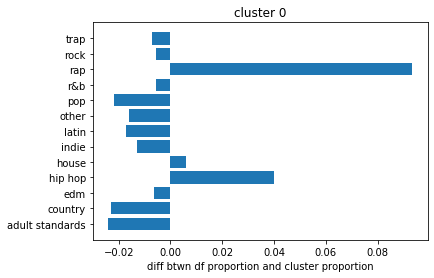

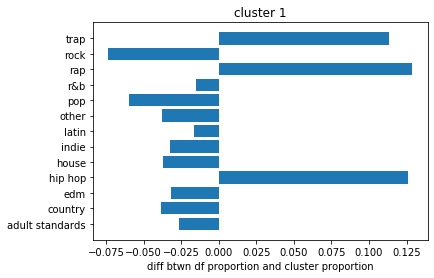

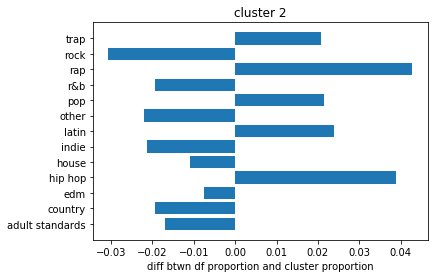

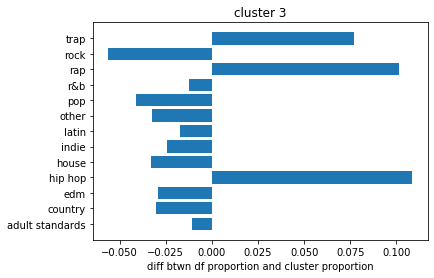

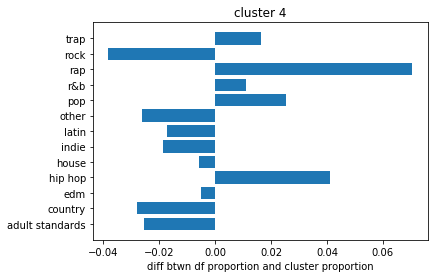

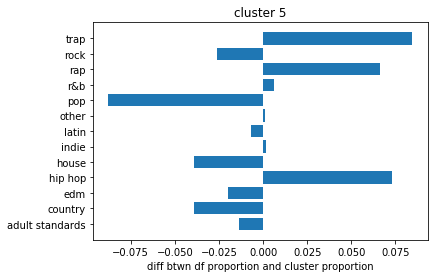

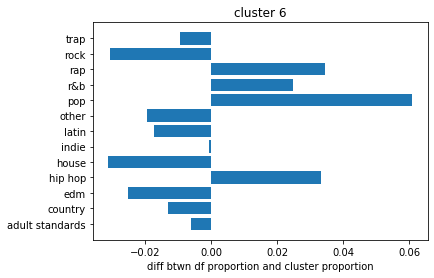

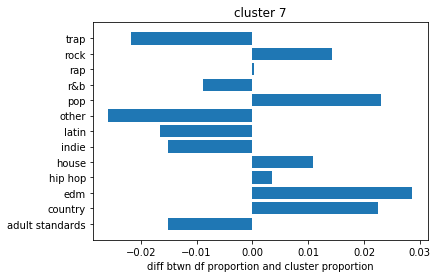

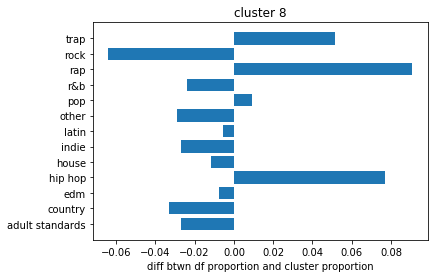

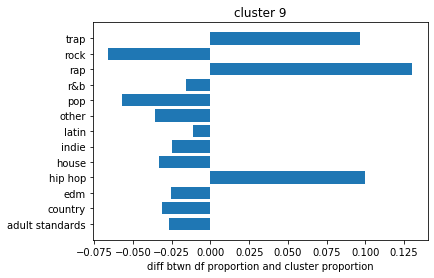

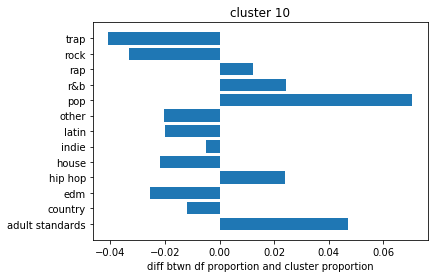

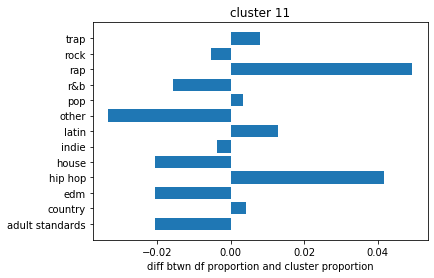

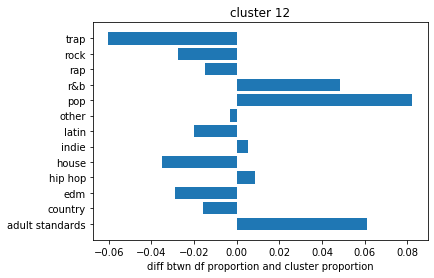

In [111]:
for i in prop_diffs.keys():
    plt.barh(range(0,len(prop_diffs[i].keys())), prop_diffs[i].values())
    plt.yticks(range(0,len(prop_diffs[i].keys())), prop_diffs[i].keys())
    plt.title(f"cluster {i}")
    plt.xlabel("diff btwn df proportion and cluster proportion")
    plt.show()


In [112]:
classify_chisq(total_genre_props, cluster_genre_counts, prop_diffs)

{0: 'rap',
 1: 'rap',
 2: 'rap',
 3: 'hip hop',
 4: 'rap',
 5: 'trap',
 6: 'pop',
 7: 'edm',
 8: 'rap',
 9: 'rap',
 10: 'pop',
 11: 'rap',
 12: 'pop'}

In [113]:
cluster_artist_counter[1]

Counter({'Lil Pump': 3,
         'Cardi B': 6,
         'Offset': 7,
         'Khalid': 4,
         'Lil Uzi Vert': 3,
         '21 Savage': 6,
         'Kendrick Lamar': 1,
         'Migos': 13,
         'Famous Dex': 1,
         'Logic': 5,
         'Kodak Black': 2,
         'Maroon 5': 1,
         'Marshmello': 1,
         'NF': 1,
         'Gucci Mane': 8,
         'Eminem': 3,
         'Miguel': 1,
         'Travis Scott': 5,
         'Lil Xan': 1,
         'Drake': 15,
         'The Chainsmokers': 1,
         'NAV': 8,
         'Taylor Swift': 1,
         'Huncho Jack': 4,
         'XXXTENTACION': 11,
         'A Boogie Wit da Hoodie': 2,
         '6ix9ine': 3,
         'Future': 17,
         'Shawn Mendes': 1,
         'BTS': 1,
         'Sam Hunt': 1,
         'Rich The Kid': 9,
         'Quality Control': 6,
         '2 Chainz': 2,
         'Young Thug': 16,
         'Bad Bunny': 4,
         'blackbear': 1,
         'Trippie Redd': 8,
         'Russ': 4,
         'GoldLink': 